In [1]:
import pandas as pd
import numpy as np
import time
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial import distance
from scipy.sparse import vstack
import torch
from sentence_transformers import SentenceTransformer
from warnings import simplefilter

/root/USTORY/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Calculate precision and recall for each class     
def compute_class_precision_recall(L,K):
  '''
    Compute the partitions matrix P which stores the size
    of the intersection of elements belong to Label i and Cluster j
    in the (i,j)-th entry of P

    Input:
      L -- Numpy array of Labels or numpy 2d array with shape (1,N_L) or (N_L,1)
      K -- Numpy array of Clusters or numpy 2d array with shape (1,N_K) or (N_K,1)

    Output:
      P -- Numpy ndarray |L| x |K| Partitions Matrix, where |L| is the
          size of the label set, and K is the number of clusters
  ''' 
  # Make everything nicely formatted. Ignore skipped labels or clusters  
  _,L = np.unique(np.array(L),return_inverse=True)
  _,K = np.unique(np.array(K),return_inverse=True)

  # Check that there are the same number of labels and clusters 
  if(len(L) != len(K)):
    sys.stderr.write("Labels and clusters are not of the same length.")
    sys.exit(1)

  # Extract some useful variables that will make things easier to read.
  # 1. Number of total elements to cluster
  # 2. Number of distinct labels
  # 3. Number of distinct clusters
  num_elements = len(L)
  num_labels   = L.max() + 1
  num_clusters = K.max() + 1

  # Create binary num_elements x num_labels / num_clusters assignment matrices. 
  X_L = np.tile(L, (num_labels,1) ).T
  X_K = np.tile(K, (num_clusters,1) ).T

  L_j = np.equal( np.tile(np.arange(num_labels),(num_elements,1))   , X_L ).astype(float)
  K_j = np.equal( np.tile(np.arange(num_clusters),(num_elements,1)) , X_K ).astype(float)   

  # Create the partitions matrix which has an element for the 
  # intersection of label i, and cluster j. The element of the matrix is the
  # Number of elements in that partition.
  P_ij = np.dot(L_j.T,K_j) 

  # Summing over the appropriate axes gives the total number of elements
  # in each class label (S_i) or cluster T_i
  S_i  = P_ij.sum(axis=1)
  T_i  = P_ij.sum(axis=0)

  # Calculate Class recall and precision
  R_i  = ( P_ij * P_ij ).sum(axis=1) / ( S_i * S_i )
  P_i  = ( P_ij.T * P_ij.T ).sum(axis=1) / ( T_i * T_i )

  return [(P_i , R_i) , (S_i , T_i)]

# Calculate b3 metrics  
def calc_b3(L , K , class_norm=False, beta=1.0):
  '''
    Implements the BCUBED algorithm according to the DESCRIPTION OF THE UPENN
    CAMP SYSTEM AS USED FOR COREFERENCE, Breck Baldwin, Tom Morton, 
    Amit Bagga, Jason Baldridge, Raman Chandraseker, Alexis Dimitriadis, 
    Kieran Snyder, Magdalena Wolska, Institute for Research in Cognitive 
    Science.

    Usage:
      from B3 import B3
      import numpy as np

      score = B3()
      L = np.array([1,3,3,3,3,4,2,2,2,3,3])
      K = np.array([1,2,3,4,5,5,5,6,2,1,1])

      # Standard BCUBED (Weight each element equally)
      [fmeasure, precision, recall] = score.calc_b3(L,K)
      
      # Equivalence class normalization (Weight each class equally)
      [fmeasure, precision, recall] = score.calc_b3(L,K,class_norm=True)

      # Different weighting schemes for fmeasure
      [fmeasure, precision, recall] = score.calc_b3(L,K,beta=2.0)
      [fmeasure, precision, recall] = score.calc_b3(L,K,beta=0.5)


    Computes the precision, recall, and fmeasure from the Class level
    precision, and recall arrays. Two types are possible. One weights all
    classes equally while the other weights each element equally.

    Input:
      L -- Numpy array of Labels or numpy 2d array with shape (1,N_L) or (N_L,1)
      K -- Numpy array of Clusters or numpy 2d array with shape (1,N_K) or (N_K,1)

      options:
        class_norm: Decides whether to weight the precision by class or by entity
        beta: Harmonic mean weighting
  '''
  
  # Compute per equivalence class precision and recall
  precision_recall , class_sizes = compute_class_precision_recall(L,K)
  
  # Two methods of obtaining overall precision and recall
  if(class_norm == True):
    precision = precision_recall[0].sum() / class_sizes[1].size 
    recall    = precision_recall[1].sum() / class_sizes[0].size
  else:
    precision = ( precision_recall[0] * class_sizes[1] ).sum() / class_sizes[1].sum()
    recall    = ( precision_recall[1] * class_sizes[0] ).sum() / class_sizes[0].sum()
  
  # f_measure with option beta to weight the precision and recall asymmetrically.
  f_measure = (1 + beta**2) * (precision * recall) /( (beta**2) * precision + recall ) 
  
  return [f_measure,precision,recall]      


In [3]:
import pandas as pd
import numpy as np
import time
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial import distance
from scipy.sparse import vstack
import torch
from sentence_transformers import SentenceTransformer
from warnings import simplefilter

# ignore scikit-learn’s token_pattern notice
simplefilter(action="ignore", category=FutureWarning)


# ---------- helper: spherical k-means via unit-norm + vanilla KMeans ----------
def spherical_kmeans(X, n_clusters, random_state=0):
    """
    Run spherical k-means by ℓ2-normalising the data, fitting KMeans,
    and re-normalising centroids.  Returns (labels, centres).
    """
    Xn = normalize(X)  # unit-length samples
    km = KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
    labels = km.fit_predict(Xn)
    centres = normalize(km.cluster_centers_)
    return labels, centres


# ------------------------------------------------------------------------------
def simulate(
    file_path,
    window_size,
    slide_size,
    num_windows,
    min_articles,
    N,
    T,
    keyword_score,
    verbose,
    story_label,
    time_aware=True,
    theme_aware=True,
):

    article_df, all_vocab = read_dataset(file_path, story_label, verbose)
    begin_date = article_df.date.iloc[0].strftime("%Y-%m-%d")

    all_window, window, cluster_keywords_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    window_indices, article_df_slides = [], []
    eval_metrics, win_proc_times = [], []

    article_df["cluster"] = -1
    article_df["sim"] = 0.0
    cluster_centers = []

    for i in range(num_windows):
        init_start_time = time.time()
        if verbose:
            print(f"<Window {i}>")

        # [1] build slide -------------------------------------------------------
        from_date = pd.to_datetime(begin_date) + pd.DateOffset(days=i * slide_size)
        to_date = pd.to_datetime(begin_date) + pd.DateOffset(days=(i + 1) * slide_size)
        slide = article_df[
            (article_df["date"] >= from_date) & (article_df["date"] < to_date)
        ].copy()

        if len(window_indices) >= window_size / slide_size:
            all_window = pd.concat([all_window, window.loc[window_indices[0]]])
            window.drop(index=window_indices[0], inplace=True)
            window_indices.pop(0)
            article_df_slides.pop(0)

        if len(slide) < 1:
            article_df_slide = np.zeros(len(all_vocab)).reshape(1, -1)
        else:
            article_TFs = vstack(slide["article_TF"])
            article_df_slide = np.bincount(
                article_TFs.indices, minlength=article_TFs.shape[1]
            ).reshape(1, -1)

        window_indices.append(slide.index)
        article_df_slides.append(article_df_slide)

        # embeddings -----------------------------------------------------------
        slide, _ = get_article_embedding(
            slide,
            window,
            article_df_slides,
            time_aware,
            theme_aware,
            keyword_score,
            N,
        )
        window = pd.concat([window, slide])

        # [2] initialise clusters ---------------------------------------------
        if len(cluster_centers) == 0:
            num_new_clusters = int(len(window) / min_articles)
            if num_new_clusters < 1:
                continue
            X = np.vstack(window["embedding"].values)
            labels, centres = spherical_kmeans(X, num_new_clusters, random_state=0)
            cluster_centers = centres.tolist()
            if verbose:
                print(f"{len(cluster_centers)} clusters are initialized")

            cluster_emb_sum_dics = [{} for _ in range(len(cluster_centers))]
            cluster_tf_sum_dics = [{} for _ in range(len(cluster_centers))]
            cluster_topN_probs = {}

            initial = True
            window, cluster_emb_sum_dics, cluster_tf_sum_dics, _ = assign_to_clusters(
                initial,
                verbose,
                window,
                window_size,
                to_date,
                cluster_centers,
                cluster_emb_sum_dics,
                cluster_tf_sum_dics,
                cluster_topN_probs,
                T,
            )

        # [2b] assign new points after init ------------------------------------
        elif (
            len(set(window[window["cluster"] >= 0]["cluster"])) > 0
            and len(window[window["cluster"] == -1]) > 0
        ):
            initial = False
            window, cluster_emb_sum_dics, cluster_tf_sum_dics, _ = assign_to_clusters(
                initial,
                verbose,
                window,
                window_size,
                to_date,
                cluster_centers,
                cluster_emb_sum_dics,
                cluster_tf_sum_dics,
                cluster_topN_probs,
                T,
                time_aware,
                theme_aware,
                cluster_topN_indices,
                cluster_topN_scores,
            )

        # [3] cluster outliers --------------------------------------------------
        window, cluster_centers, cluster_emb_sum_dics, cluster_tf_sum_dics, _ = cluster_outliers(
            window,
            cluster_centers,
            cluster_emb_sum_dics,
            cluster_tf_sum_dics,
            min_articles,
            verbose,
        )

        # [4] theme keywords ----------------------------------------------------
        if len(set(window[window["cluster"] >= 0]["cluster"])) > 0:
            (
                cluster_topN_indices,
                cluster_topN_scores,
                cluster_topN_probs,
                _,
            ) = get_cluster_theme(
                window,
                window_size,
                to_date,
                time_aware,
                cluster_tf_sum_dics,
                keyword_score,
                N,
            )

        # stats -----------------------------------------------------------------
        if len(window) > 0:
            if i >= window_size and story_label:
                eval_metrics.append(
                    eval_metric(window.story.values, window.cluster.values)
                )
            win_proc_times.append(time.time() - init_start_time)
            cluster_keywords_df = update_cluster_keywords_articles(
                i, window, all_vocab, cluster_keywords_df, cluster_topN_indices
            )

    all_window = pd.concat([all_window, window])

    if story_label:
        nmi, ami, ri, ari, precision, recall, fscore = [
            np.round(k, 3) for k in np.mean(eval_metrics, axis=0)
        ]
    else:
        nmi, ami, ri, ari, precision, recall, fscore = [0] * 7

    final_num_cluster = len(cluster_centers)
    avg_win_proc_time = np.round(np.mean(win_proc_times), 1)

    return (
        all_window,
        cluster_keywords_df,
        final_num_cluster,
        avg_win_proc_time,
        nmi,
        ami,
        ri,
        ari,
        precision,
        recall,
        fscore,
    )


# ------------------------------- utilities ------------------------------------
def read_dataset(file_name, story_label, verbose):
    article_df = pd.read_json(file_name)
    article_df["sentence_embds"] = [np.array(x) for x in article_df["sentence_embds"]]

    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1, 2), tokenizer=lambda x: x, lowercase=False, norm=None
    )
    tfidf_vectorizer.fit_transform([sum(k, []) for k in article_df["sentence_tokens"]])
    all_vocab = tfidf_vectorizer.get_feature_names_out().tolist()

    count_vectorizer = CountVectorizer(
        tokenizer=lambda x: x,
        ngram_range=(1, 2),
        vocabulary=list(all_vocab),
        lowercase=False,
    )
    article_df["sentence_TFs"] = [
        count_vectorizer.transform(y) for y in article_df["sentence_tokens"].values
    ]
    article_df["article_TF"] = [sum(a) for a in article_df["sentence_TFs"].values]

    if verbose:
        print(f"{file_name} loaded")
        print(f"articles:{len(article_df)}")
        if story_label:
            print(f"#stories:{len(article_df.story.unique())}")

    return article_df, all_vocab


def eval_metric(label, cluster):
    nmi = np.round(metrics.normalized_mutual_info_score(label, cluster), 3)
    ami = np.round(metrics.adjusted_mutual_info_score(label, cluster), 3)
    ri = np.round(metrics.rand_score(label, cluster), 3)
    ari = np.round(metrics.adjusted_rand_score(label, cluster), 3)
    fscore, precision, recall = [np.round(k, 3) for k in calc_b3(label, cluster)]
    return [nmi, ami, ri, ari, precision, recall, fscore]

def get_article_embedding(slide, window, article_df_slides, time_aware, theme_aware, keyword_score, N):
    start_time = time.time()
    if len(slide) < 1:
        return slide, time.time() - start_time      
     
    if theme_aware:
        num_articles = len(window) if len(window) > 0 else len(slide)
        
        if time_aware: #exponential decaying document frequency
            article_df_window = 0 
            for t in range(len(article_df_slides)):
                article_df_window += np.exp(-(len(article_df_slides)-t-1)/len(article_df_slides))*article_df_slides[t]
        else: #document frequency
            article_df_window = np.sum(article_df_slides,axis=0) 
        
        article_idf_window = np.log((num_articles+1)/(article_df_window+1))+1 #inverse document frequency - scikit-learn formual = log((N+1)/(df+1))+1
        article_tf_window = vstack(slide['article_TF'].values) #term frequency
              
        if keyword_score == 'tfidf':
            article_keyword_score_all = article_tf_window.multiply(article_idf_window).tocsr()
        elif keyword_score == 'bm25':
            k1 = 1.2
            b = 0.75
            d = 1.0
            
            avgDL =  np.sum(vstack(window['article_TF'].values))/num_articles if len(window) > 0 else np.sum(vstack(slide['article_TF'].values))/num_articles #average document length
            article_ntf_window = article_tf_window.multiply(1/np.array(1-b+b*np.sum(article_tf_window,axis=1)/avgDL)) # normalized term frequency - pivoted length normalization - eq3 in Yuanhua 2011
            article_ntf_window.data = article_ntf_window.data # shifting - eq4 in Yuanhua 2011
            article_ntf_window.data = ((k1 + 1) * article_ntf_window.data)  / (k1 + article_ntf_window.data)  + d # tf normalization - eq4 in Yuanhua 2011
            article_keyword_score_all = article_ntf_window.multiply(article_idf_window).tocsr()
        
    weighted_embs = []
    num_processed_articles = 0
    for (idx,article) in slide.iterrows():
        if theme_aware:
            article_topN_indices = article_keyword_score_all[num_processed_articles].indices[article_keyword_score_all[num_processed_articles].data.argsort()[:-(N+1):-1]]
            article_topN_scores = article_keyword_score_all[num_processed_articles][:,article_topN_indices]
            sentence_raw_weights = np.array(np.sum(article.sentence_TFs[:,article_topN_indices].multiply(article_topN_scores), axis=1)).ravel() + 1e-5
            sentence_weights = sentence_raw_weights / np.sum(sentence_raw_weights, axis=0)
            num_processed_articles += 1
        else:
            num_sentences = len(article['sentences'])
            sentence_weights = [1/num_sentences]* num_sentences 
        weighted_embs.append(np.matmul(sentence_weights,article.sentence_embds))
    
    slide['embedding'] = weighted_embs
    
    return slide, time.time() - start_time


from scipy.sparse import csr_matrix, vstack

def get_cluster_theme(window, window_size, to_date,
                      time_aware, cluster_tf_sum_dics,
                      keyword_score, N):
    """
    Derive top-N keywords for each live cluster.

    Fixes:
      • skip clusters that still have *zero* term-frequency rows  
      • ensure every item passed to vstack is a csr_matrix  
      • short-circuit early and return empties if no clusters survive  
    """
    start_time = time.time()
    cluster_ids = list(set(window[window["cluster"] >= 0]["cluster"]))

    # ---------------------------------------------------------------- collect TF vectors
    cluster_tf_dic = {}
    for cid in cluster_ids:
        if time_aware:
            tf_sum = None
            decaying_factor = window_size
            for date in sorted(cluster_tf_sum_dics[cid].keys())[::-1]:
                delta = (to_date - date).days - 1
                if delta >= window_size:
                    break
                weight = np.exp(-delta / decaying_factor)
                vec = weight * cluster_tf_sum_dics[cid][date]
                tf_sum = vec if tf_sum is None else tf_sum + vec
            # tf_sum might still be None if the cluster is completely empty
            if tf_sum is not None:
                cluster_tf_dic[cid] = tf_sum
        else:
            tf_sum = window[window["cluster"] == cid].article_TF
            if len(tf_sum) > 0:
                cluster_tf_dic[cid] = np.sum(tf_sum)

    # no cluster has any term-frequency data yet
    if not cluster_tf_dic:
        empty = {}, {}, {}, time.time() - start_time
        return empty

    # ---------------------------------------------------------------- TF/IDF + BM25 prep
    tf_list = []
    for tf_vec in cluster_tf_dic.values():
        if not isinstance(tf_vec, csr_matrix):
            # convert 1-d np.array or 0-d to 1×V sparse
            tf_vec = csr_matrix(tf_vec)
        tf_list.append(tf_vec)

    cluster_tf = vstack(tf_list)
    cluster_df = np.bincount(cluster_tf.indices,
                             minlength=cluster_tf.shape[1]).reshape(1, -1)
    cluster_idf = np.log((len(tf_list) + 1) / (cluster_df + 1)) + 1

    if keyword_score == "tfidf":
        cluster_keyword_score_all = cluster_tf.multiply(cluster_idf).tocsr()
    elif keyword_score == "bm25":
        k1, b, d = 1.2, 0.75, 1.0
        avgDL = np.sum(cluster_tf) / len(tf_list)
        cluster_ntf = cluster_tf.multiply(
            1 / np.array(1 - b + b * np.sum(cluster_tf, axis=1) / avgDL)
        )
        cluster_ntf.data = ((k1 + 1) * cluster_ntf.data) / (k1 + cluster_ntf.data) + d
        cluster_keyword_score_all = cluster_ntf.multiply(cluster_idf).tocsr()

    # ---------------------------------------------------------------- pick top-N tokens
    cluster_topN_indices = {}
    cluster_topN_scores = {}
    cluster_topN_probs = {}

    for i, cid in enumerate(cluster_tf_dic.keys()):
        top_idx = cluster_keyword_score_all[i].indices[
            cluster_keyword_score_all[i].data.argsort()[: -(N + 1) : -1]
        ]
        cluster_topN_indices[cid] = top_idx
        cluster_topN_scores[cid] = cluster_keyword_score_all[i][:, top_idx]

        # compute normalised TF as probability for Jensen–Shannon sims
        top_tf = cluster_tf_dic[cid][:, top_idx]
        probs = (top_tf / np.sum(top_tf)).toarray()[0]
        cluster_topN_probs[cid] = [round(x, 5) for x in probs]

    return (
        cluster_topN_indices,
        cluster_topN_scores,
        cluster_topN_probs,
        time.time() - start_time,
    )

def assign_to_clusters(initial, verbose, window, window_size, to_date, cluster_centers, 
                       cluster_emb_sum_dics, cluster_tf_sum_dics, cluster_topN_probs,
                       T, time_aware = False, theme_aware = False, 
                       cluster_topN_indices = None, cluster_topN_scores = None):
    
    start_time = time.time()

    if initial:
        considered_center_indices = list(range(len(cluster_centers)))
    else:
        considered_center_indices = list(set(window[window['cluster']>=0]['cluster']))

    if verbose: print("Assign to "+str(len(considered_center_indices))+" clusters")
    out_thred = (1-1/(len(considered_center_indices)+1))**T #+1 to handle a single cluster

    if theme_aware:
        sentence_tfs_all = vstack(window[window.cluster==-1]['sentence_TFs'].values)
        article_tfs_all = vstack(window[window.cluster==-1]['article_TF'].values)
        sentence_raw_weights_all = {}
        article_topN_tfs_all = {}
        for cluster_id in considered_center_indices:
            sentence_raw_weights_all[cluster_id] = np.array(np.sum(sentence_tfs_all[:,cluster_topN_indices[cluster_id]].multiply(cluster_topN_scores[cluster_id]), axis=1)).ravel()                       
            article_topN_tfs_all[cluster_id] = article_tfs_all[:,cluster_topN_indices[cluster_id]].toarray()
            
    if time_aware:
        time_weighted_center_dic = {}
        decaying_factor = window_size           # keep one variable, reuse
    
        for uniq_date in window[window.cluster == -1]["date"].unique():
            for cluster_id in considered_center_indices:
    
                # ------- accumulate embedding sums and weights
                time_weighted_sum = 0
                time_weighted_num = 0           # use a scalar, no need for list
    
                for date, (emb_sum, count) in cluster_emb_sum_dics[cluster_id].items():
                    # skip if outside the window
                    delta = (to_date - date).days - 1
                    if delta >= window_size:
                        continue
    
                    w = np.exp(-abs((uniq_date - date).days) / decaying_factor)
                    time_weighted_sum += w * emb_sum
                    time_weighted_num += w * count
    
                # ------- choose safe centre
                if time_weighted_num == 0:
                    # fallback: old static centre
                    centre = cluster_centers[cluster_id]
                else:
                    centre = time_weighted_sum / time_weighted_num
    
                time_weighted_center_dic[(pd.Timestamp(uniq_date), cluster_id)] = centre

            
    num_processed_articles = 0
    num_processed_sentences = 0
    for (idx,article) in window[window.cluster==-1].iterrows():
        w_emb = article.embedding # default article embedding
        
        ## Evaluate the similarity to clusters
        if theme_aware:
            similarities = []
            total_weighted_embeddings = []

            for cluster_id in considered_center_indices:                
                sentence_raw_weights = np.array(sentence_raw_weights_all[cluster_id][num_processed_sentences:num_processed_sentences + len(article.sentences)]).ravel()
                if sum(sentence_raw_weights) > 0:
                    sentence_weights = sentence_raw_weights / np.sum(sentence_raw_weights)
                    c_emb = np.matmul(sentence_weights,article.sentence_embds)
                    
                    total_weighted_emb = c_emb
                else: #if any of sentence is weighted, then just use default embedding
                    total_weighted_emb = w_emb 

                total_weighted_embeddings.append(total_weighted_emb)

                if time_aware:
                    time_weighted_center = time_weighted_center_dic[(article['date'], cluster_id)]
                    cos_sim = np.dot(total_weighted_emb, time_weighted_center)/(np.linalg.norm(total_weighted_emb)*np.linalg.norm(time_weighted_center))
                else:
                    cos_sim = np.dot(total_weighted_emb, cluster_centers[int(cluster_id)])/(np.linalg.norm(total_weighted_emb)*np.linalg.norm(cluster_centers[int(cluster_id)]))
                
                if sum(sentence_raw_weights) > 0:
                    article_topN_tfs = article_topN_tfs_all[cluster_id][num_processed_articles]
                    p_cluster  = cluster_topN_probs[cluster_id]
                    p_article = (article_topN_tfs/np.sum(article_topN_tfs))
                    js_sim = 1 - distance.jensenshannon(p_cluster,p_article)
                else:
                    js_sim = 0
                
                if cos_sim < 0: cos_sim = 0
                similarities.append(cos_sim*js_sim)
            num_processed_sentences += len(article.sentences)
            num_processed_articles += 1
        else:
            if time_aware:
                similarities = []
                for cluster_id in considered_center_indices:
                    time_weighted_center = time_weighted_center_dic[(article['date'], cluster_id)]
                    cos_sim = np.dot(article.embedding, time_weighted_center)/(np.linalg.norm(article.embedding)*np.linalg.norm(time_weighted_center))
                    similarities.append(cos_sim)
            else:
                considered_centers = [cluster_centers[int(k)] for k in considered_center_indices]
                similarities = cosine_similarity([article.embedding], considered_centers)
        
        probs = np.exp(T*np.array(similarities)).ravel()
        probs = probs/np.sum(probs)
       
        ## Assign to the most appropriate cluster
        if not initial and len(probs) < 2:
            conf = np.max(similarities) #if a single cluster
        else:
            conf = np.max(probs)
        if 1-conf > out_thred:
            window.at[idx,'cluster'] = -1
            window.at[idx,'sim'] = 0
        else:
            cluster_id = considered_center_indices[np.argmax(probs)]
            window.at[idx,'cluster'] = cluster_id
            window.at[idx,'sim'] = np.max(probs)
            
            if theme_aware: #update embedding
                window.at[idx,'embedding'] = total_weighted_embeddings[np.argmax(probs)]

            if article['date'] not in cluster_emb_sum_dics[cluster_id]:
                cluster_emb_sum_dics[cluster_id][article['date']] = [0,0]
                cluster_tf_sum_dics[cluster_id][article['date']] = 0
            cluster_emb_sum_dics[cluster_id][article['date']][0] += article['embedding'] #embedding sum
            cluster_emb_sum_dics[cluster_id][article['date']][1] += 1 #article count
            cluster_tf_sum_dics[cluster_id][article['date']] += article['article_TF'] #article tf sum

    return window, cluster_emb_sum_dics, cluster_tf_sum_dics, time.time() - start_time


def cluster_outliers(
        window,
        cluster_centers,
        cluster_emb_sum_dics,
        cluster_tf_sum_dics,
        min_articles,
        verbose=False):
    """
    Re-cluster the current outliers (articles with cluster == -1).
    Any newly created cluster must contain at least `min_articles` members.
    Uses spherical k-means implemented via unit-norm + sklearn.KMeans.
    """
    start_time = time.time()

    # ------------------------------------------------------------------ locate outliers
    out_idx = window[window["cluster"] == -1].index
    num_new_clusters = int(len(out_idx) / min_articles)

    # ------------------------------------------------------------------ conditional recluster
    if num_new_clusters > 1:
        Xo = np.vstack(window.loc[out_idx, "embedding"].values)
        # cosine ⇔ Euclidean after ℓ2-normalisation
        o_labels, o_centers = spherical_kmeans(Xo, num_new_clusters, random_state=0)

        cluster_id_dic, new_centers = {}, []
        next_id = len(cluster_centers)

        # only keep clusters with at least `min_articles` members
        for label in set(o_labels):
            if list(o_labels).count(label) < min_articles:
                continue
            cluster_id_dic[label] = next_id
            new_centers.append(o_centers[label])
            cluster_emb_sum_dics.append({})
            cluster_tf_sum_dics.append({})
            if verbose:
                size = list(o_labels).count(label)
                print(f"A new cluster {next_id} of {size} articles is created")
            next_id += 1

        # ---------------------------------------------------------------- update assignments
        for i, art_idx in enumerate(out_idx):
            lbl = o_labels[i]
            if lbl in cluster_id_dic:
                cid = cluster_id_dic[lbl]
                window.at[art_idx, "cluster"] = cid
                article_date = window.at[art_idx, "date"]

                cluster_emb_sum_dics[cid].setdefault(article_date, [0, 0])
                cluster_tf_sum_dics[cid].setdefault(article_date, 0)

                # update running sums
                cluster_emb_sum_dics[cid][article_date][0] += window.at[art_idx, "embedding"]
                cluster_emb_sum_dics[cid][article_date][1] += 1
                cluster_tf_sum_dics[cid][article_date] += window.at[art_idx, "article_TF"]
            else:
                # remains an outlier
                window.at[art_idx, "cluster"] = -1

        # append the new centroids (already unit-normalised)
        cluster_centers = np.array(list(cluster_centers) + new_centers)

    # ------------------------------------------------------------------ return unchanged API
    return (
        window,
        cluster_centers,
        cluster_emb_sum_dics,
        cluster_tf_sum_dics,
        time.time() - start_time,
    )


def update_cluster_keywords_articles(i, window, all_vocab, cluster_keywords_df, cluster_topN_indices):
    for k in cluster_topN_indices.keys(): 
        if k not in cluster_keywords_df.columns:
            cluster_keywords_df[k] = ''
            cluster_keywords_df[k] = cluster_keywords_df[k].astype('object')
        cluster_keywords_df.at[i,k] = ''
        cluster_keywords_df.at[i,k] = [all_vocab[i] for i in cluster_topN_indices[k]]
    return cluster_keywords_df

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def visualize_clusters(df,
                       sample=1500,
                       dim_red="pca",
                       figsize=(8, 6),
                       random_state=0):
    """
    Visualise article clusters in 2-D.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'embedding' (1-D list/ndarray) and 'cluster'.
    sample : int or None
        Sub-sample size for faster plotting; None takes all points.
    dim_red : {"pca", "tsne"}
        Dimensionality-reduction method.
    figsize : tuple
        Figure size passed to matplotlib.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    coords_2d : np.ndarray
        (n_points, 2) array of projected coordinates.
    """
    if sample and len(df) > sample:
        df_vis = df.sample(sample, random_state=random_state)
    else:
        df_vis = df.copy()

    X = np.vstack(df_vis["embedding"].values)

    if dim_red.lower() == "tsne":
        reducer = TSNE(
            n_components=2,
            perplexity=min(30, len(df_vis) // 5),
            learning_rate="auto",
            init="pca",
            random_state=random_state,
        )                                   # see best-practice tips :contentReference[oaicite:3]{index=3}
    else:
        reducer = PCA(n_components=2, random_state=random_state)

    coords = reducer.fit_transform(X)

    # ---- plotting ----------------------------------------------------------
    plt.figure(figsize=figsize)
    sc = plt.scatter(
        coords[:, 0],
        coords[:, 1],
        c=df_vis["cluster"],
        s=np.clip(df_vis["sim"] * 200, 20, 200),
        cmap="tab20",
        alpha=0.7,
    )
    plt.colorbar(sc, label="Cluster ID")
    plt.title(f"{len(df_vis):,} articles – {df_vis['cluster'].nunique()} clusters")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()                               # pandas-mate chart display :contentReference[oaicite:4]{index=4}

    # ---- cluster summary table --------------------------------------------
    summary = (
        df.groupby("cluster")
          .agg(size=("id", "count"),
               avg_sim=("sim", "mean"),
               earliest=("date", "min"),
               latest=("date", "max"))
          .sort_values("size", ascending=False)
    )
    display(summary.head(25))                # Jupyter inline table :contentReference[oaicite:5]{index=5}
    print("MEAN: ", summary['avg_sim'].mean())

    return coords

def inspect_cluster(df, cluster_id, n=15, show_text=False):
    subset = (df[df['cluster'] == cluster_id]
              .sort_values('sim', ascending=False)
              .head(n)
              .reset_index(drop=True))
    cols = ['id', 'date', 'sim', 'title']
    if show_text and 'text' in df.columns:
        cols.append('text')
    display(subset[cols])

def cluster_browser(df):
    if not _HAS_WIDGETS:
        print("ipywidgets is not installed. Install it with `pip install ipywidgets` "
              "or just call inspect_cluster(df, cluster_id).")
        return
    cluster_ids = sorted(df['cluster'].unique())
    dropdown = w.Dropdown(options=cluster_ids,
                          description='Cluster:',
                          continuous_update=False)
    slider = w.IntSlider(value=10, min=5, max=50, step=5,
                         description='Rows:')
    toggle = w.ToggleButton(value=False,
                            description='Show text',
                            button_style='')
    out = w.Output()
    def update(*args):
        out.clear_output()
        with out:
            inspect_cluster(df, dropdown.value,
                            n=slider.value,
                            show_text=toggle.value)
    dropdown.observe(update, names='value')
    slider.observe(update, names='value')
    toggle.observe(update, names='value')
    display(w.VBox([w.HBox([dropdown, slider, toggle]), out]))


In [18]:
def cluster_summary(df, min_size=1):
    """
    Return a DataFrame with per‑cluster statistics.

    Columns: size, avg_sim, earliest, latest
    """
    summary = (df.groupby("cluster")
                 .agg(size=("id", "count"),
                      avg_sim=("sim", "mean"),
                      earliest=("date", "min"),
                      latest=("date", "max"))
                 .query("size >= @min_size")
                 .sort_values("avg_sim", ascending=False))
    return summary

def top_clusters(df, top_n=3, min_size=1, show_text=False):
    """
    Show the `top_n` clusters ranked by average similarity.
    """
    summary = cluster_summary(df, min_size=min_size)
    display(summary.head(top_n))

    for cid in summary.head(top_n).index:
        print(f"\n=== Cluster {cid} | size={summary.at[cid, 'size']} "
              f"| avg_sim={summary.at[cid, 'avg_sim']:.3f} ===")
        inspect_cluster(df, cid, n=15, show_text=show_text)

/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


scraped-articles/preprocessed.json loaded
articles:1000
<Window 0>
58 clusters are initialized
Assign to 58 clusters
A new cluster 58 of 35 articles is created
A new cluster 59 of 26 articles is created
A new cluster 60 of 31 articles is created
<Window 1>
Assign to 61 clusters
A new cluster 61 of 22 articles is created
A new cluster 62 of 21 articles is created
A new cluster 63 of 18 articles is created
<Window 2>
Assign to 64 clusters
A new cluster 64 of 22 articles is created
A new cluster 65 of 17 articles is created
<Window 3>
Assign to 66 clusters
<Window 4>
Assign to 14 clusters


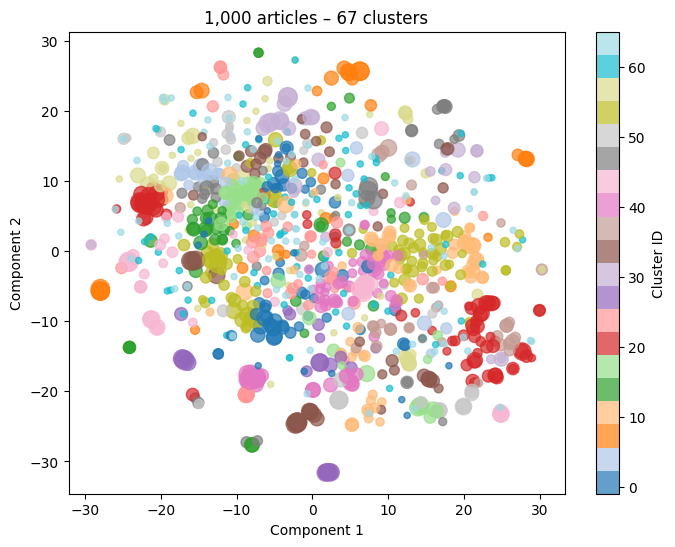

,size,avg_sim,earliest,latest
cluster,,,,
52,50,0.246889,2025-05-11,2025-05-31
41,44,0.280573,2025-05-11,2025-05-17
58,35,0.000000,2025-05-11,2025-05-17
17,32,0.335788,2025-05-11,2025-05-16
60,31,0.000000,2025-05-11,2025-05-17
2,27,0.374425,2025-05-11,2025-06-03
59,26,0.000000,2025-05-11,2025-05-17
19,23,0.390409,2025-05-11,2025-05-17
14,22,0.307851,2025-05-11,2025-05-16


MEAN:  0.37405482173552124


In [19]:
all_window, *_ = simulate("scraped-articles/preprocessed.json",
                          window_size=22, slide_size=7, num_windows=5,
                          min_articles=15, N=10, T=10,
                          keyword_score="tfidf", verbose=True,
                          story_label=False)

# then visualise
coords2d = visualize_clusters(all_window, dim_red="tsne", sample=2000)

In [20]:
# see which clusters have the highest internal coherence
top_clusters(all_window, top_n=10, min_size=5)

# get the full table if you need it
cluster_summary(all_window, min_size=10).head(10)

,size,avg_sim,earliest,latest
cluster,,,,
40,13,0.770354,2025-05-11,2025-05-16
42,7,0.740653,2025-05-11,2025-05-16
26,5,0.732902,2025-05-11,2025-05-11
34,10,0.690802,2025-05-11,2025-05-17
30,7,0.642967,2025-05-11,2025-05-14
20,20,0.613751,2025-05-11,2025-05-16
31,8,0.609541,2025-05-11,2025-05-14
8,7,0.585021,2025-05-11,2025-05-11
28,9,0.572148,2025-05-11,2025-05-19



=== Cluster 40 | size=13 | avg_sim=0.770 ===


,id,date,sim,title
0,744,2025-05-16,0.889514,AI language models develop social norms like g...
1,655,2025-05-14,0.884589,Republicans Try to Cram Ban on AI Regulation I...
2,783,2025-05-16,0.876786,New attack can steal cryptocurrency by plantin...
3,553,2025-05-14,0.875237,AI Tool 'Track' Helps Police Bypass Facial Rec...
4,227,2025-05-11,0.822746,One-Minute Daily AI News 5/10/2025
5,733,2025-05-16,0.816851,DeepMind Researcher: AlphaEvolve May Have Alre...
6,436,2025-05-12,0.805407,This video shows if the Totally Spies girls we...
7,433,2025-05-12,0.768786,One-Minute Daily AI News 5/11/2025
8,371,2025-05-11,0.755197,AI Company Asks Job Applicants Not to Use AI i...
9,648,2025-05-14,0.747387,One-Minute Daily AI News 5/13/2025



=== Cluster 42 | size=7 | avg_sim=0.741 ===


,id,date,sim,title
0,120,2025-05-11,0.899207,The Pope chose the name Leo because he is very...
1,81,2025-05-11,0.888260,Pope Leo XIV names AI one of the reasons for h...
2,391,2025-05-12,0.787184,Leo XIV (Bachelor of Science degree in mathema...
3,275,2025-05-11,0.729508,"Pope Leo XIV: ""AI poses new challenges re: hum..."
4,247,2025-05-11,0.711980,Pope Leo references AI in his explanation of w...
5,774,2025-05-16,0.668360,Top Priority for Pope Leo: Warn the World of t...
6,346,2025-05-11,0.500071,The Pope chose the name Leo because of AI



=== Cluster 26 | size=5 | avg_sim=0.733 ===


,id,date,sim,title
0,137,2025-05-11,0.926704,Fandom sells gaming media brand Giant Bomb to ...
1,205,2025-05-11,0.850673,Giant Bomb is now owned by the people who make...
2,176,2025-05-11,0.815093,Giant Bomb goes independent
3,271,2025-05-11,0.636617,Fandom Sells Giant Bomb to Independent Creators
4,74,2025-05-11,0.435422,Embracer Games Archive is preserving 75000 vid...



=== Cluster 34 | size=10 | avg_sim=0.691 ===


,id,date,sim,title
0,21,2025-05-11,0.940251,Fortnite applies to launch on Apple's App Stor...
1,791,2025-05-16,0.931577,Apple blocks Fortnite&#8217;s App Store return...
2,824,2025-05-16,0.909754,Fortnite is now offline on iOS worldwide as Ap...
3,801,2025-05-16,0.874348,Tim Sweeney is mocking Apple for letting Fortn...
4,393,2025-05-12,0.699201,The iPhone Is a Nicer Place With Fewer Restric...
5,30,2025-05-11,0.616545,Apple says Epic Games contempt ruling could co...
6,171,2025-05-11,0.612060,How iPhone Apps Are Changing After a Recent Ap...
7,787,2025-05-16,0.559013,Viral outrage over Apple’s EU payment warnings...
8,830,2025-05-17,0.514990,"Apple Pay services resolved after outage, comp..."
9,94,2025-05-11,0.250281,Build iOS Apps on Linux and Windows (WSL)



=== Cluster 30 | size=7 | avg_sim=0.643 ===


,id,date,sim,title
0,607,2025-05-14,0.867241,Enhanced Importance Sampling through Latent Sp...
1,529,2025-05-14,0.791232,A Point-Based Algorithm for Distributional Rei...
2,514,2025-05-14,0.782327,Online Feedback Efficient Active Target Discov...
3,549,2025-05-14,0.639344,Bias or Optimality? Disentangling Bayesian Inf...
4,483,2025-05-14,0.618333,Value Iteration with Guessing for Markov Chain...
5,557,2025-05-14,0.549185,Behind the Noise: Conformal Quantile Regressio...
6,86,2025-05-11,0.253110,Adventures in Imbalanced Learning and Class We...



=== Cluster 20 | size=20 | avg_sim=0.614 ===


,id,date,sim,title
0,397,2025-05-12,0.901001,LPT: Got an old low VRAM GPU you're not using?...
1,103,2025-05-11,0.898632,(Dual?) 5060Ti 16gb or 3090 for gaming+ML?
2,374,2025-05-11,0.889909,"Own a RTX3080 10GB, is it good if I sidegrade ..."
3,455,2025-05-14,0.888883,rtx 4090 vs rtx 5090 vs rtx 4090 48gb vram?
4,331,2025-05-11,0.885382,Anyone here with a 50 series using GTX card fo...
5,772,2025-05-16,0.879016,GPU recommendations For starter
6,653,2025-05-14,0.679920,Two RTX 6000 Pro Blackwell..what's it get you?
7,323,2025-05-11,0.671614,Thinking about hardware for local LLMs? Here's...
8,742,2025-05-16,0.607725,Simple generation speed test with 2x Arc B580
9,512,2025-05-14,0.605063,AMD Ryzen AI Max+ PRO 395 Linux Benchmarks



=== Cluster 31 | size=8 | avg_sim=0.610 ===


,id,date,sim,title
0,196,2025-05-11,0.908173,Absolute Zero: Reinforced Self-Play Reasoning ...
1,306,2025-05-11,0.896877,Absolute Zero: Reinforced Self-play Reasoning ...
2,561,2025-05-14,0.620135,An Identifiable Cost-Aware Causal Decision-Mak...
3,322,2025-05-11,0.558060,Absolute Zero: Reinforced Self-play Reasoning ...
4,475,2025-05-14,0.510978,Causal knowledge graph analysis identifies adv...
5,680,2025-05-14,0.496970,On Definite Iterated Belief Revision with Beli...
6,466,2025-05-14,0.448858,Beyond Patterns: Harnessing Causal Logic for A...
7,208,2025-05-11,0.436273,P-1 Trinity Dispatch



=== Cluster 8 | size=7 | avg_sim=0.585 ===


,id,date,sim,title
0,4,2025-05-11,0.883711,Whoop launches two new wearables with 14-day b...
1,264,2025-05-11,0.862117,Whoop Reverses Course After Customer Backlash ...
2,44,2025-05-11,0.860248,Fitness tracker Whoop faces unhappy customers ...
3,112,2025-05-11,0.745427,Whoop backpedals on its paid upgrade whoops
4,232,2025-05-11,0.295778,Engineers develop wearable heart attack detect...
5,293,2025-05-11,0.240623,Adidas’ 3D-printed sneaker review: What are th...
6,212,2025-05-11,0.207246,"Remember Moviefone? Well, it’s back."



=== Cluster 28 | size=9 | avg_sim=0.572 ===


,id,date,sim,title
0,750,2025-05-16,0.768736,Musk’s xAI says Grok's 'white genocide' posts ...
1,793,2025-05-16,0.755283,Grok&#8217;s white genocide fixation caused by...
2,611,2025-05-14,0.751904,Musk's xAI chatbot Grok keeps randomly respond...
3,795,2025-05-16,0.745250,Musk's Grok AI chatbot says it 'appears that I...
4,704,2025-05-16,0.697926,Musk’s xAI Blames Rogue Tampering for ‘White G...
5,916,2025-05-19,0.547203,Grok says it’s ‘skeptical’ about Holocaust dea...
6,705,2025-05-16,0.342875,Grok intentionally misaligned - forced to take...
7,337,2025-05-11,0.322582,Teenager Fatally Shot During ‘Ding Dong Ditch’...
8,817,2025-05-16,0.217575,Anthropic’s lawyer was forced to apologize aft...



=== Cluster 55 | size=5 | avg_sim=0.561 ===


,id,date,sim,title
0,383,2025-05-11,0.757459,Time to First Token and Tokens/second
1,456,2025-05-14,0.567539,Inside the LLM Black Box: What Goes Into Conte...
2,177,2025-05-11,0.520019,JEP 515: Ahead-of-Time Method Profiling
3,62,2025-05-11,0.491358,[D] POV: You get this question in your intervi...
4,547,2025-05-14,0.470550,Deeper insights into retrieval augmented gener...


,size,avg_sim,earliest,latest
cluster,,,,
40,13,0.770354,2025-05-11,2025-05-16
34,10,0.690802,2025-05-11,2025-05-17
20,20,0.613751,2025-05-11,2025-05-16
7,13,0.518190,2025-05-11,2025-05-16
39,11,0.466253,2025-05-11,2025-05-14
21,10,0.432211,2025-05-11,2025-05-17
18,10,0.416742,2025-05-11,2025-05-17
57,12,0.394949,2025-05-11,2025-05-17
19,23,0.390409,2025-05-11,2025-05-17


In [8]:
# %% PARAMETER SWEEP

In [9]:
import time, itertools, csv, sys, pathlib
import pandas as pd

# ----------------------------------------------------------------
# >>> 1.  CONFIGURE HERE  <<<
# ----------------------------------------------------------------
DATA_PATH      = "scraped-articles/preprocessed.json"     # <- your dataset
OUT_CSV        = "results_sweep1.csv"
VERBOSE_SIM    = False          # turn on if you need window-level logs
SEED           = 0              # for reproducibility

# ----------------------------------------------------------------
# >>> 2.  PARAMETER GRID  <<<
# ----------------------------------------------------------------
BASELINE = dict(
    window_size   = 14,
    slide_size    = 7,
    num_windows   = 10,      #  <-- NEW!  set to whatever makes sense (5, 8, …)
    min_articles  = 15,
    N             = 10,
    T             = 2,
    keyword_score = "tfidf",
    time_aware    = True,
    theme_aware   = True,
)

SWEEPS = [
    # (name, list of values to try, key to substitute)
    ("window_size", [7, 10, 21], "window_size"),                  # 50 % overlap rule
    ("min_articles", [5, 10, 20], "min_articles"),
    ("N_keywords",  [3, 5, 15], "N"),
    ("temperature", [1, 3, 5], "T"),
    ("keyword_score", ["bm25"], "keyword_score"),                 # tfidf already baseline
    ("ablation_time", [False], "time_aware"),
    ("ablation_theme", [False], "theme_aware"),
]

# ----------------------------------------------------------------
# >>> 3.  RUNNER  <<<
# ----------------------------------------------------------------

def run_single(cfg: dict):
    """Run one simulate() call, return flat dict of params+metrics."""
    t0 = time.time()
    (
        df, _, final_clusters, avg_win_time,
        nmi, ami, ri, ari, prec, rec, fscore
    ) = simulate(DATA_PATH,
                 verbose     = VERBOSE_SIM,
                 story_label = False,
                 **cfg)
    elapsed = round(time.time() - t0, 1)

    return {**cfg,
            "final_num_cluster": final_clusters,
            "avg_win_proc_time": avg_win_time,
            "wall_clock_s"     : elapsed,
            "nmi": nmi, "ami": ami, "ri": ri, "ari": ari,
            "precision": prec, "recall": rec, "f1_b3": fscore}

# ----------------------------------------------------------------
# >>> 4.  EXPERIMENT LOOP  <<<
# ----------------------------------------------------------------
results = []

# 4-a  Baseline once
results.append(run_single(BASELINE))

# 4-b  One-at-a-time sweeps
for sweep_name, values, key in SWEEPS:
    for val in values:
        cfg = BASELINE.copy()
        cfg[key] = val
        # maintain 50 % overlap if we changed the window length
        if key == "window_size":
            cfg["slide_size"] = cfg["window_size"] // 2 or 1
        run_tag = f"{sweep_name}={val}"
        print(f"[ RUN ] {run_tag}", file=sys.stderr)
        results.append(run_single(cfg))

# ----------------------------------------------------------------
# >>> 5.  SAVE + PRINT  <<<
# ----------------------------------------------------------------
df_results = pd.DataFrame(results)
df_results.insert(0, "run_id", range(1, len(df_results)+1))
df_results.to_csv(OUT_CSV, index=False)
print("\n===== CSV OUTPUT =====")
print(df_results.to_csv(index=False))

print(f"\n✓  Finished {len(df_results)} runs "
      f"→ results saved to  {pathlib.Path(OUT_CSV).resolve()}")

/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
[ RUN ] window_size=7
/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
[ RUN ] window_size=10
/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
[ RUN ] window_size=21
/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
[ RUN ] min_articles=5
/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pat


===== CSV OUTPUT =====
run_id,window_size,slide_size,num_windows,min_articles,N,T,keyword_score,time_aware,theme_aware,final_num_cluster,avg_win_proc_time,wall_clock_s,nmi,ami,ri,ari,precision,recall,f1_b3
1,14,7,10,15,10,2,tfidf,True,True,75,0.4,3.5,0,0,0,0,0,0,0
2,7,3,10,15,10,2,tfidf,True,True,52,0.1,2.9,0,0,0,0,0,0,0
3,10,5,10,15,10,2,tfidf,True,True,65,0.3,3.2,0,0,0,0,0,0,0
4,21,10,10,15,10,2,tfidf,True,True,74,0.4,3.3,0,0,0,0,0,0,0
5,14,7,10,5,10,2,tfidf,True,True,191,0.7,4.9,0,0,0,0,0,0,0
6,14,7,10,10,10,2,tfidf,True,True,101,0.4,3.5,0,0,0,0,0,0,0
7,14,7,10,20,10,2,tfidf,True,True,58,0.3,3.0,0,0,0,0,0,0,0
8,14,7,10,15,3,2,tfidf,True,True,74,0.3,3.1,0,0,0,0,0,0,0
9,14,7,10,15,5,2,tfidf,True,True,73,0.4,3.3,0,0,0,0,0,0,0
10,14,7,10,15,15,2,tfidf,True,True,73,0.4,3.2,0,0,0,0,0,0,0
11,14,7,10,15,10,1,tfidf,True,True,58,0.3,3.1,0,0,0,0,0,0,0
12,14,7,10,15,10,3,tfidf,True,True,78,0.4,3.2,0,0,0,0,0,0,0
13,14,7,10,15,10,5,tfidf,True,True,70,0.4,3.1,0,0,0,0,0,0,0
14,14,7,10,15,10,2,bm25

In [10]:
# ------------ USER CONFIG -------------
DATA_PATH   = "scraped-articles/preprocessed.json"
OUT_CSV     = "results_grid_T_vs_minArt.csv"
VERBOSE_SIM = False
USE_LABELS  = False          # <-- set False if your JSON lacks `story`
# --------------------------------------

GRID_MIN_ART  = [10, 15, 20]
GRID_T        = [1, 2, 3, 4]

BASE = dict(
    window_size = 14,
    slide_size  = 7,
    num_windows = 10,
    N           = 10,
    keyword_score = "tfidf",
    time_aware  = True,
    theme_aware = True,
)

def run(cfg):
    t0 = time.time()
    df, *rest = simulate(
        DATA_PATH, verbose=VERBOSE_SIM,
        story_label=USE_LABELS, **cfg
    )

    (_ckw,                     # cluster_keywords_df (ignored)
     final_clusters,
     avg_win_time,
     nmi, ami, ri, ari,
     prec, rec, f1) = rest

    # unsupervised tightness proxy
    mean_sim = df.groupby('cluster')['sim'].mean().mean()

    # ---------- RETURN A DICT -------------
    return {
        **cfg,
        "final_clusters": final_clusters,
        "avg_win_s":      avg_win_time,
        "wall_s":         round(time.time() - t0, 1),
        "mean_sim":       round(mean_sim, 3),
        "nmi": nmi, "ari": ari, "f1_b3": f1
    }

rows = []
for m in GRID_MIN_ART:
    for T in GRID_T:
        cfg = BASE | dict(min_articles=m, T=T)
        print(f"[ RUN ] min_articles={m}  T={T}", file=sys.stderr)
        rows.append(run(cfg))

df = pd.DataFrame(rows)
df.insert(0, "run_id", range(1, len(df)+1))
df.to_csv(OUT_CSV, index=False)
print("\n===== CSV OUTPUT =====")
print(df.to_csv(index=False))
print("\n✓ Done →", pathlib.Path(OUT_CSV).resolve())


[ RUN ] min_articles=10  T=1
/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
[ RUN ] min_articles=10  T=2
/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/tmp/ipykernel_124974/4009703900.py:592: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_keywords_df[k] = ''
[ RUN ] min_articles=10  T=3
/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not 


===== CSV OUTPUT =====
run_id,window_size,slide_size,num_windows,N,keyword_score,time_aware,theme_aware,min_articles,T,final_clusters,avg_win_s,wall_s,mean_sim,nmi,ari,f1_b3
1,14,7,10,10,tfidf,True,True,10,1,87,0.4,3.7,0.019,0,0,0
2,14,7,10,10,tfidf,True,True,10,2,101,0.4,3.6,0.028,0,0,0
3,14,7,10,10,tfidf,True,True,10,3,101,0.4,3.7,0.045,0,0,0
4,14,7,10,10,tfidf,True,True,10,4,100,0.5,3.7,0.074,0,0,0
5,14,7,10,10,tfidf,True,True,15,1,58,0.3,3.1,0.027,0,0,0
6,14,7,10,10,tfidf,True,True,15,2,75,0.4,3.2,0.035,0,0,0
7,14,7,10,10,tfidf,True,True,15,3,78,0.4,3.5,0.05,0,0,0
8,14,7,10,10,tfidf,True,True,15,4,73,0.4,3.2,0.08,0,0,0
9,14,7,10,10,tfidf,True,True,20,1,43,0.3,3.0,0.035,0,0,0
10,14,7,10,10,tfidf,True,True,20,2,58,0.3,3.1,0.042,0,0,0
11,14,7,10,10,tfidf,True,True,20,3,61,0.3,3.1,0.061,0,0,0
12,14,7,10,10,tfidf,True,True,20,4,59,0.3,3.1,0.092,0,0,0


✓ Done → /root/USTORY/results_grid_T_vs_minArt.csv


In [11]:
# %% TEST SOME GOOD PARAMS

/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


scraped-articles/preprocessed.json loaded
articles:1000
<Window 0>
58 clusters are initialized
Assign to 58 clusters
A new cluster 58 of 19 articles is created
A new cluster 59 of 18 articles is created
A new cluster 60 of 34 articles is created
A new cluster 61 of 18 articles is created
A new cluster 62 of 36 articles is created
A new cluster 63 of 16 articles is created
A new cluster 64 of 29 articles is created
A new cluster 65 of 16 articles is created
A new cluster 66 of 61 articles is created
A new cluster 67 of 21 articles is created
<Window 1>
Assign to 68 clusters
A new cluster 68 of 45 articles is created
A new cluster 69 of 16 articles is created
A new cluster 70 of 23 articles is created
<Window 2>
Assign to 6 clusters
A new cluster 71 of 15 articles is created
A new cluster 72 of 27 articles is created
<Window 3>
Assign to 2 clusters
<Window 4>
<Window 5>
<Window 6>
<Window 7>
<Window 8>
<Window 9>
<Window 10>
<Window 11>
<Window 12>
<Window 13>
<Window 14>


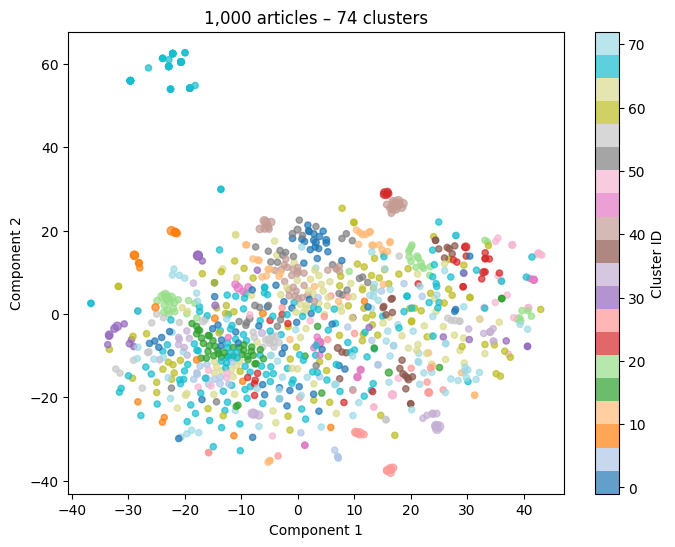

,size,avg_sim,earliest,latest
cluster,,,,
67,89,0.056748,2025-05-11,2025-05-22
66,61,0.000000,2025-05-11,2025-05-17
68,45,0.000000,2025-05-11,2025-05-22
62,36,0.000000,2025-05-11,2025-05-17
60,34,0.000000,2025-05-11,2025-05-17
-1,33,0.000000,2025-05-11,2025-06-03
64,29,0.000000,2025-05-11,2025-05-17
72,27,0.000000,2025-05-18,2025-05-31
41,27,0.080358,2025-05-11,2025-05-17


MEAN:  0.07920749031876852


,size,avg_sim,earliest,latest
cluster,,,,
40,13,0.164210,2025-05-11,2025-05-16
34,9,0.151172,2025-05-11,2025-05-17
42,7,0.148316,2025-05-11,2025-05-16
26,5,0.143349,2025-05-11,2025-05-11
20,19,0.135572,2025-05-11,2025-05-16
30,6,0.133818,2025-05-14,2025-05-14
23,5,0.126998,2025-05-12,2025-05-16
31,8,0.121011,2025-05-11,2025-05-14
28,8,0.114311,2025-05-11,2025-05-19



=== Cluster 40 | size=13 | avg_sim=0.164 ===


,id,date,sim,title
0,744,2025-05-16,0.210565,AI language models develop social norms like g...
1,655,2025-05-14,0.206338,Republicans Try to Cram Ban on AI Regulation I...
2,553,2025-05-14,0.200082,AI Tool 'Track' Helps Police Bypass Facial Rec...
3,783,2025-05-16,0.200023,New attack can steal cryptocurrency by plantin...
4,436,2025-05-12,0.178285,This video shows if the Totally Spies girls we...
5,227,2025-05-11,0.171228,One-Minute Daily AI News 5/10/2025
6,733,2025-05-16,0.168169,DeepMind Researcher: AlphaEvolve May Have Alre...
7,433,2025-05-12,0.153880,One-Minute Daily AI News 5/11/2025
8,371,2025-05-11,0.147292,AI Company Asks Job Applicants Not to Use AI i...
9,648,2025-05-14,0.147107,One-Minute Daily AI News 5/13/2025



=== Cluster 34 | size=9 | avg_sim=0.151 ===


,id,date,sim,title
0,21,2025-05-11,0.231195,Fortnite applies to launch on Apple's App Stor...
1,791,2025-05-16,0.221654,Apple blocks Fortnite&#8217;s App Store return...
2,824,2025-05-16,0.192334,Fortnite is now offline on iOS worldwide as Ap...
3,801,2025-05-16,0.175811,Tim Sweeney is mocking Apple for letting Fortn...
4,393,2025-05-12,0.126273,The iPhone Is a Nicer Place With Fewer Restric...
5,30,2025-05-11,0.114337,Apple says Epic Games contempt ruling could co...
6,171,2025-05-11,0.109671,How iPhone Apps Are Changing After a Recent Ap...
7,787,2025-05-16,0.099569,Viral outrage over Apple’s EU payment warnings...
8,830,2025-05-17,0.089702,"Apple Pay services resolved after outage, comp..."



=== Cluster 42 | size=7 | avg_sim=0.148 ===


,id,date,sim,title
0,120,2025-05-11,0.191102,The Pope chose the name Leo because he is very...
1,81,2025-05-11,0.172726,Pope Leo XIV names AI one of the reasons for h...
2,275,2025-05-11,0.144571,"Pope Leo XIV: ""AI poses new challenges re: hum..."
3,391,2025-05-12,0.142038,Leo XIV (Bachelor of Science degree in mathema...
4,247,2025-05-11,0.140773,Pope Leo references AI in his explanation of w...
5,774,2025-05-16,0.139093,Top Priority for Pope Leo: Warn the World of t...
6,346,2025-05-11,0.107909,The Pope chose the name Leo because of AI



=== Cluster 26 | size=5 | avg_sim=0.143 ===


,id,date,sim,title
0,137,2025-05-11,0.214023,Fandom sells gaming media brand Giant Bomb to ...
1,205,2025-05-11,0.163697,Giant Bomb is now owned by the people who make...
2,176,2025-05-11,0.150691,Giant Bomb goes independent
3,271,2025-05-11,0.111501,Fandom Sells Giant Bomb to Independent Creators
4,74,2025-05-11,0.076830,Embracer Games Archive is preserving 75000 vid...



=== Cluster 20 | size=19 | avg_sim=0.136 ===


,id,date,sim,title
0,397,2025-05-12,0.211474,LPT: Got an old low VRAM GPU you're not using?...
1,103,2025-05-11,0.199130,(Dual?) 5060Ti 16gb or 3090 for gaming+ML?
2,455,2025-05-14,0.195683,rtx 4090 vs rtx 5090 vs rtx 4090 48gb vram?
3,374,2025-05-11,0.190929,"Own a RTX3080 10GB, is it good if I sidegrade ..."
4,331,2025-05-11,0.186415,Anyone here with a 50 series using GTX card fo...
5,772,2025-05-16,0.184063,GPU recommendations For starter
6,653,2025-05-14,0.136315,Two RTX 6000 Pro Blackwell..what's it get you?
7,742,2025-05-16,0.133849,Simple generation speed test with 2x Arc B580
8,224,2025-05-11,0.124816,Local LLM Build with CPU and DDR5: Thoughts on...
9,248,2025-05-11,0.124470,Best local and free AI image generator for 8GB...



=== Cluster 30 | size=6 | avg_sim=0.134 ===


,id,date,sim,title
0,607,2025-05-14,0.173353,Enhanced Importance Sampling through Latent Sp...
1,529,2025-05-14,0.151974,A Point-Based Algorithm for Distributional Rei...
2,514,2025-05-14,0.146894,Online Feedback Efficient Active Target Discov...
3,549,2025-05-14,0.117643,Bias or Optimality? Disentangling Bayesian Inf...
4,483,2025-05-14,0.115411,Value Iteration with Guessing for Markov Chain...
5,557,2025-05-14,0.097634,Behind the Noise: Conformal Quantile Regressio...



=== Cluster 23 | size=5 | avg_sim=0.127 ===


,id,date,sim,title
0,562,2025-05-14,0.128055,Canada Created a New Artificial Intelligence M...
1,646,2025-05-14,0.127826,How a New Type of AI is Helping Police Circumv...
2,754,2025-05-16,0.127667,ROBO DOCS Inside the cutting-edge NHS wards wh...
3,434,2025-05-12,0.126422,Microsoft and OpenAI Renegotiate Multibillion-...
4,736,2025-05-16,0.125019,Very interesting conversation between NYtimes ...



=== Cluster 31 | size=8 | avg_sim=0.121 ===


,id,date,sim,title
0,196,2025-05-11,0.202347,Absolute Zero: Reinforced Self-Play Reasoning ...
1,306,2025-05-11,0.192817,Absolute Zero: Reinforced Self-play Reasoning ...
2,561,2025-05-14,0.111994,An Identifiable Cost-Aware Causal Decision-Mak...
3,322,2025-05-11,0.099810,Absolute Zero: Reinforced Self-play Reasoning ...
4,680,2025-05-14,0.093870,On Definite Iterated Belief Revision with Beli...
5,475,2025-05-14,0.090541,Causal knowledge graph analysis identifies adv...
6,466,2025-05-14,0.089881,Beyond Patterns: Harnessing Causal Logic for A...
7,208,2025-05-11,0.086831,P-1 Trinity Dispatch



=== Cluster 28 | size=8 | avg_sim=0.114 ===


,id,date,sim,title
0,750,2025-05-16,0.141870,Musk’s xAI says Grok's 'white genocide' posts ...
1,795,2025-05-16,0.140011,Musk's Grok AI chatbot says it 'appears that I...
2,611,2025-05-14,0.138774,Musk's xAI chatbot Grok keeps randomly respond...
3,793,2025-05-16,0.137510,Grok&#8217;s white genocide fixation caused by...
4,704,2025-05-16,0.127503,Musk’s xAI Blames Rogue Tampering for ‘White G...
5,916,2025-05-19,0.087912,Grok says it’s ‘skeptical’ about Holocaust dea...
6,705,2025-05-16,0.071243,Grok intentionally misaligned - forced to take...
7,337,2025-05-11,0.069668,Teenager Fatally Shot During ‘Ding Dong Ditch’...



=== Cluster 18 | size=6 | avg_sim=0.111 ===


,id,date,sim,title
0,770,2025-05-16,0.141957,Coinbase Hack Rocks Company That Led Crypto In...
1,843,2025-05-17,0.129045,Coinbase Hack Highlights How Greed Can Overwhe...
2,834,2025-05-17,0.111878,Coinbase Hack Could Have Wide-Ranging Impact
3,7,2025-05-11,0.104300,Coinbase acquires crypto derivatives exchange ...
4,849,2025-05-17,0.099870,Coinbase Boosted by S&amp;P 500 Inclusion Desp...
5,68,2025-05-11,0.080550,Swissquote Seeks to Shake Crypto Link Despite ...


,size,avg_sim,earliest,latest
cluster,,,,
40,13,0.164210,2025-05-11,2025-05-16
20,19,0.135572,2025-05-11,2025-05-16
7,12,0.101320,2025-05-11,2025-05-16
54,11,0.094583,2025-05-11,2025-05-16
39,10,0.092992,2025-05-11,2025-05-14
3,12,0.091129,2025-05-11,2025-05-16
2,22,0.090000,2025-05-11,2025-05-17
10,11,0.089971,2025-05-11,2025-05-16
12,16,0.089131,2025-05-11,2025-05-17


In [33]:
all_window, *_ = simulate("scraped-articles/preprocessed.json",
                          window_size=10, slide_size=7, num_windows=15,
                          min_articles=15, N=10, T=4,
                          keyword_score="tfidf", verbose=True,
                          story_label=False)

# then visualise
coords2d = visualize_clusters(all_window, dim_red="tsne", sample=2000)

# see which clusters have the highest internal coherence
top_clusters(all_window, top_n=10, min_size=5)

# get the full table if you need it
cluster_summary(all_window, min_size=10).head(10)

In [31]:
for T in [3, 5, 7, 10]:
    df, *_ = simulate("scraped-articles/preprocessed.json",
                      window_size=22, slide_size=7, num_windows=5,
                      min_articles=15, N=10, T=T,
                      keyword_score="tfidf", verbose=False,
                      story_label=False)

    # --- coherence based on cosine to per-cluster centroid -------------
    centroids = (df
                 .groupby('cluster')['embedding']
                 .apply(lambda embs: np.mean(np.vstack(embs), axis=0)))

    cos_to_centroid = []
    for idx, row in df.iterrows():
        c = row['cluster']
        art_emb = row['embedding']
        cen_emb = centroids[c]
        cos = np.dot(art_emb, cen_emb) / (
               np.linalg.norm(art_emb) * np.linalg.norm(cen_emb))
        cos_to_centroid.append(cos)

    mean_cos = np.mean(cos_to_centroid)
    print(f"T={T:<2}  mean_cos={mean_cos:.3f}")


/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


T=3   mean_cos=0.644


/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


T=5   mean_cos=0.649


/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


T=7   mean_cos=0.644


/root/USTORY/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


T=10  mean_cos=0.635


In [47]:
#!/usr/bin/env python3
import time, sys, pathlib, itertools, pandas as pd
import numpy as np                     # ←———— use real NumPy, not pandas.np

# ---------- COMMON -----------------------------------------------------------
DATA_PATH   = "scraped-articles/preprocessed.json"
VERBOSE_SIM = False
USE_LABELS  = False
SEED        = 0

def coherence_metrics(df):
    """mean-cosine to centroid • % outliers • cluster-size Gini."""
    # 1) centroids
    centroids = (df.groupby('cluster')['embedding']
                   .apply(lambda embs: np.mean(np.vstack(embs), axis=0)))

    # 2) article-to-centroid cosine
    def art_cos(row):
        c = row['cluster']; e = row['embedding']; cen = centroids[c]
        return (e @ cen) / (np.linalg.norm(e) * np.linalg.norm(cen))

    cos_mean    = df.apply(art_cos, axis=1).mean()
    outlier_pct = (df['cluster'] == -1).mean()

    # 3) size Gini
    sizes = df[df['cluster'] != -1].groupby('cluster')['id'].count()
    if len(sizes) > 1:
        diff_sum  = np.abs(sizes.values[:, None] - sizes.values[None, :]).sum()
        size_gini = diff_sum / (2 * len(sizes) * sizes.values.sum())
    else:
        size_gini = 0.0

    return round(cos_mean, 3), round(outlier_pct, 3), round(size_gini, 3)

def run_once(params: dict):
    t0 = time.time()
    df, *_stats = simulate(DATA_PATH,
                           verbose     = VERBOSE_SIM,
                           story_label = USE_LABELS,
                           **params)
    (_ckw,
     n_cluster, avg_win_sec,
     nmi, ami, ri, ari,
     prec, rec, f1) = _stats

    cos, out_pct, gini = coherence_metrics(df)
    return { **params,
             "clusters": n_cluster,
             "avg_win_s": avg_win_sec,
             "wall_s":    round(time.time()-t0,1),
             "mean_cos":  cos,
             "outlier_pct": out_pct,
             "gini_size": gini,
             "nmi": nmi, "ari": ari, "f1_b3": f1 }

def sweep(grid, base_cfg, out_csv):
    rows = []
    for combo in grid:
        cfg = base_cfg | combo
        tag = ", ".join(f"{k}={v}" for k,v in combo.items())
        print(f"[ RUN ] {tag}", file=sys.stderr)
        rows.append(run_once(cfg))

    df = pd.DataFrame(rows)
    df.insert(0, "run_id", range(1, len(df)+1))
    df.to_csv(out_csv, index=False)

    # --- always echo CSV to stdout so you can copy over SSH
    print(f"\n===== {out_csv} =====")
    print(df.to_csv(index=False))          # ← prints the full CSV
    print("✓ saved to", pathlib.Path(out_csv).resolve(), "\n")

# ---------------- 1) TIGHT-STORY SWEEP --------------------------------------
base_tight = dict(
    window_size = 14,  slide_size=7,  num_windows=10,
    N=10, keyword_score="tfidf", time_aware=True, theme_aware=True,
)
tight_grid = [
    dict(min_articles=m, T=T, window_size=ws, slide_size=ws//2 or 1)
    for m  in [5, 10]
    for T  in [3, 4, 5]
    for ws in [7, 10, 14]
]
sweep(tight_grid, base_tight, "results_tight.csv")

# ---------------- 2) THEMATIC SWEEP -----------------------------------------
base_theme = dict(
    window_size = 28, slide_size=14, num_windows=8,
    keyword_score="tfidf", time_aware=True, theme_aware=True,
)
theme_grid = [
    dict(min_articles=m, T=T, N=N)
    for m in [20, 30]
    for T in [3, 4]
    for N in [10, 15]
]
sweep(theme_grid, base_theme, "results_theme.csv")


[ RUN ] min_articles=5, T=3, window_size=7, slide_size=3
[ RUN ] min_articles=5, T=3, window_size=10, slide_size=5
[ RUN ] min_articles=5, T=3, window_size=14, slide_size=7
[ RUN ] min_articles=5, T=4, window_size=7, slide_size=3
[ RUN ] min_articles=5, T=4, window_size=10, slide_size=5
[ RUN ] min_articles=5, T=4, window_size=14, slide_size=7
[ RUN ] min_articles=5, T=5, window_size=7, slide_size=3
[ RUN ] min_articles=5, T=5, window_size=10, slide_size=5
[ RUN ] min_articles=5, T=5, window_size=14, slide_size=7
[ RUN ] min_articles=10, T=3, window_size=7, slide_size=3
[ RUN ] min_articles=10, T=3, window_size=10, slide_size=5
[ RUN ] min_articles=10, T=3, window_size=14, slide_size=7
[ RUN ] min_articles=10, T=4, window_size=7, slide_size=3
[ RUN ] min_articles=10, T=4, window_size=10, slide_size=5
[ RUN ] min_articles=10, T=4, window_size=14, slide_size=7
[ RUN ] min_articles=10, T=5, window_size=7, slide_size=3
[ RUN ] min_articles=10, T=5, window_size=10, slide_size=5
[ RUN ] min_


===== results_tight.csv =====
run_id,window_size,slide_size,num_windows,N,keyword_score,time_aware,theme_aware,min_articles,T,clusters,avg_win_s,wall_s,mean_cos,outlier_pct,gini_size,nmi,ari,f1_b3
1,7,3,10,10,tfidf,True,True,5,3,152,0.2,3.7,0.697,0.021,0.418,0,0,0
2,10,5,10,10,tfidf,True,True,5,3,168,0.5,4.2,0.733,0.028,0.413,0,0,0
3,14,7,10,10,tfidf,True,True,5,3,198,0.7,4.9,0.744,0.013,0.384,0,0,0
4,7,3,10,10,tfidf,True,True,5,4,143,0.2,3.6,0.714,0.021,0.456,0,0,0
5,10,5,10,10,tfidf,True,True,5,4,169,0.5,4.3,0.735,0.009,0.422,0,0,0
6,14,7,10,10,tfidf,True,True,5,4,193,0.8,5.3,0.745,0.007,0.404,0,0,0
7,7,3,10,10,tfidf,True,True,5,5,142,0.2,3.6,0.698,0.014,0.454,0,0,0
8,10,5,10,10,tfidf,True,True,5,5,164,0.5,4.1,0.734,0.015,0.431,0,0,0
9,14,7,10,10,tfidf,True,True,5,5,191,0.7,4.8,0.738,0.014,0.408,0,0,0
10,7,3,10,10,tfidf,True,True,10,3,82,0.2,3.1,0.631,0.023,0.417,0,0,0
11,10,5,10,10,tfidf,True,True,10,3,100,0.3,3.3,0.67,0.036,0.356,0,0,0
12,14,7,10,10,tfidf,True,True,10,3,101,0.5,3.

[ RUN ] min_articles=20, T=3, N=10
[ RUN ] min_articles=20, T=3, N=15
[ RUN ] min_articles=20, T=4, N=10
[ RUN ] min_articles=20, T=4, N=15
[ RUN ] min_articles=30, T=3, N=10
[ RUN ] min_articles=30, T=3, N=15
[ RUN ] min_articles=30, T=4, N=10
[ RUN ] min_articles=30, T=4, N=15



===== results_theme.csv =====
run_id,window_size,slide_size,num_windows,keyword_score,time_aware,theme_aware,min_articles,T,N,clusters,avg_win_s,wall_s,mean_cos,outlier_pct,gini_size,nmi,ari,f1_b3
1,28,14,8,tfidf,True,True,20,3,10,63,0.6,3.5,0.649,0.053,0.435,0,0,0
2,28,14,8,tfidf,True,True,20,3,15,62,0.6,3.2,0.664,0.048,0.443,0,0,0
3,28,14,8,tfidf,True,True,20,4,10,61,0.6,3.1,0.662,0.04,0.453,0,0,0
4,28,14,8,tfidf,True,True,20,4,15,60,0.6,3.2,0.655,0.069,0.438,0,0,0
5,28,14,8,tfidf,True,True,30,3,10,44,0.5,2.9,0.615,0.048,0.476,0,0,0
6,28,14,8,tfidf,True,True,30,3,15,46,0.5,3.0,0.604,0.058,0.468,0,0,0
7,28,14,8,tfidf,True,True,30,4,10,45,0.6,3.1,0.616,0.035,0.44,0,0,0
8,28,14,8,tfidf,True,True,30,4,15,46,0.5,2.9,0.606,0.037,0.464,0,0,0

✓ saved to /root/USTORY/results_theme.csv 



In [61]:
TIGHT = dict(
    window_size = 14,
    slide_size  = 7,
    num_windows = 10,
    min_articles= 5,
    T           = 4,     
    N           = 10,
    keyword_score = "tfidf",
    time_aware  = True,
    theme_aware = True,
    story_label = False,
    verbose     = False,

)

In [65]:
THEME = dict(
    window_size = 28,
    slide_size  = 14,
    num_windows = 8,
    min_articles= 20,   # bump to 30 if you want even larger themes
    T           = 3,
    N           = 15,   # lets the cluster centroid breathe a bit
    keyword_score = "tfidf",
    time_aware  = True,
    theme_aware = True,
    story_label = False,
    verbose     = False,
)

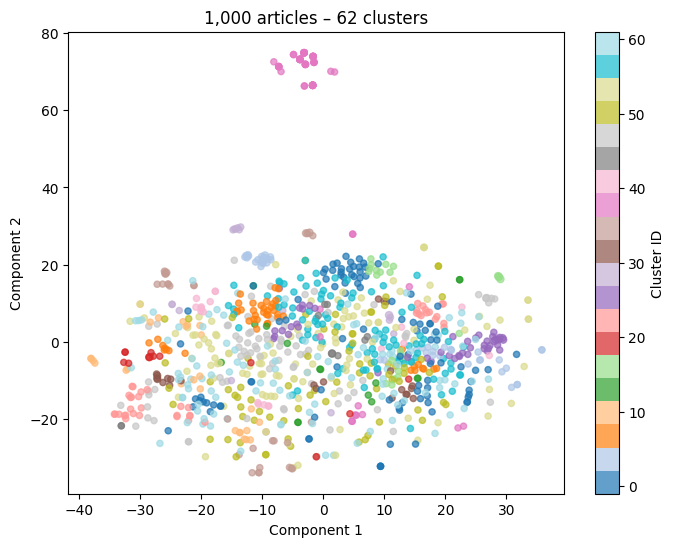

,size,avg_sim,earliest,latest
cluster,,,,
38,64,0.063828,2025-05-11,2025-05-22
54,53,0.000000,2025-05-11,2025-05-24
-1,48,0.000000,2025-05-11,2025-06-03
47,47,0.000000,2025-05-11,2025-05-22
56,45,0.003545,2025-05-11,2025-06-03
57,34,0.000000,2025-05-11,2025-05-24
53,33,0.000000,2025-05-11,2025-05-24
59,31,0.000000,2025-05-11,2025-06-03
61,31,0.000000,2025-05-11,2025-05-31


MEAN:  0.05863195462825087


,size,avg_sim,earliest,latest
cluster,,,,
4,19,0.100938,2025-05-11,2025-05-16
25,20,0.097729,2025-05-11,2025-05-16
46,5,0.097496,2025-05-11,2025-05-19
36,11,0.095683,2025-05-11,2025-05-17
30,9,0.095614,2025-05-14,2025-05-17
29,7,0.087150,2025-05-11,2025-05-19
20,10,0.085599,2025-05-11,2025-05-17
42,9,0.083857,2025-05-11,2025-05-14
12,6,0.083825,2025-05-11,2025-05-14



=== Cluster 4 | size=19 | avg_sim=0.101 ===


,id,date,sim,title
0,744,2025-05-16,0.127449,AI language models develop social norms like g...
1,783,2025-05-16,0.121452,New attack can steal cryptocurrency by plantin...
2,655,2025-05-14,0.121369,Republicans Try to Cram Ban on AI Regulation I...
3,553,2025-05-14,0.120836,AI Tool 'Track' Helps Police Bypass Facial Rec...
4,436,2025-05-12,0.120386,This video shows if the Totally Spies girls we...
5,433,2025-05-12,0.109632,One-Minute Daily AI News 5/11/2025
6,227,2025-05-11,0.109185,One-Minute Daily AI News 5/10/2025
7,733,2025-05-16,0.106388,DeepMind Researcher: AlphaEvolve May Have Alre...
8,648,2025-05-14,0.102691,One-Minute Daily AI News 5/13/2025
9,587,2025-05-14,0.100045,One-Minute Daily AI News 5/12/2025



=== Cluster 25 | size=20 | avg_sim=0.098 ===


,id,date,sim,title
0,397,2025-05-12,0.136526,LPT: Got an old low VRAM GPU you're not using?...
1,103,2025-05-11,0.130606,(Dual?) 5060Ti 16gb or 3090 for gaming+ML?
2,455,2025-05-14,0.128321,rtx 4090 vs rtx 5090 vs rtx 4090 48gb vram?
3,374,2025-05-11,0.128308,"Own a RTX3080 10GB, is it good if I sidegrade ..."
4,331,2025-05-11,0.119959,Anyone here with a 50 series using GTX card fo...
5,772,2025-05-16,0.118942,GPU recommendations For starter
6,742,2025-05-16,0.101945,Simple generation speed test with 2x Arc B580
7,653,2025-05-14,0.100384,Two RTX 6000 Pro Blackwell..what's it get you?
8,224,2025-05-11,0.097550,Local LLM Build with CPU and DDR5: Thoughts on...
9,248,2025-05-11,0.095842,Best local and free AI image generator for 8GB...



=== Cluster 46 | size=5 | avg_sim=0.097 ===


,id,date,sim,title
0,800,2025-05-16,0.125704,Here are the best Kindle deals right now
1,238,2025-05-11,0.123074,Amazon’s ad-free Kindle Paperwhite Kids has hi...
2,899,2025-05-19,0.093289,Here are the best iPad deals you can get right...
3,895,2025-05-19,0.077633,"The Sonos Move 2 is cheaper than ever, just in..."
4,803,2025-05-16,0.067782,Here are the best Apple Watch deals available ...



=== Cluster 36 | size=11 | avg_sim=0.096 ===


,id,date,sim,title
0,21,2025-05-11,0.133174,Fortnite applies to launch on Apple's App Stor...
1,791,2025-05-16,0.127776,Apple blocks Fortnite&#8217;s App Store return...
2,824,2025-05-16,0.107821,Fortnite is now offline on iOS worldwide as Ap...
3,801,2025-05-16,0.102368,Tim Sweeney is mocking Apple for letting Fortn...
4,393,2025-05-12,0.098841,The iPhone Is a Nicer Place With Fewer Restric...
5,30,2025-05-11,0.096887,Apple says Epic Games contempt ruling could co...
6,171,2025-05-11,0.091951,How iPhone Apps Are Changing After a Recent Ap...
7,787,2025-05-16,0.087417,Viral outrage over Apple’s EU payment warnings...
8,830,2025-05-17,0.070773,"Apple Pay services resolved after outage, comp..."
9,38,2025-05-11,0.068300,FTC delays enforcement of click-to-cancel rule



=== Cluster 30 | size=9 | avg_sim=0.096 ===


,id,date,sim,title
0,692,2025-05-16,0.120195,Trump and His Allies Pave Way for Unconstraine...
1,799,2025-05-16,0.113934,White House announces AI data center campus pa...
2,851,2025-05-17,0.113231,"Nvidia, Cisco, Oracle and OpenAI are backing t..."
3,555,2025-05-14,0.098634,Photos: Tech CEOs mingle with Trump and Saudi ...
4,534,2025-05-14,0.098118,"For Trump, It’s a New Era of Deal-Making With ..."
5,759,2025-05-16,0.093052,"U.S., UAE agree on path for Emirates to buy to..."
6,728,2025-05-16,0.090482,Trump’s Rush to Cut AI Deals in Saudi Arabia a...
7,522,2025-05-14,0.067194,Nvidia&#8217;s flattery of Trump wins reversal...
8,623,2025-05-14,0.065687,US Plans to Grant Saudi Arabia More Access to ...



=== Cluster 29 | size=7 | avg_sim=0.087 ===


,id,date,sim,title
0,795,2025-05-16,0.100641,Musk's Grok AI chatbot says it 'appears that I...
1,611,2025-05-14,0.096116,Musk's xAI chatbot Grok keeps randomly respond...
2,793,2025-05-16,0.095209,Grok&#8217;s white genocide fixation caused by...
3,704,2025-05-16,0.090665,Musk’s xAI Blames Rogue Tampering for ‘White G...
4,750,2025-05-16,0.086396,Musk’s xAI says Grok's 'white genocide' posts ...
5,916,2025-05-19,0.076700,Grok says it’s ‘skeptical’ about Holocaust dea...
6,316,2025-05-11,0.064321,'It cannot provide nuance': UK experts warn AI...



=== Cluster 20 | size=10 | avg_sim=0.086 ===


,id,date,sim,title
0,556,2025-05-14,0.129989,"Coinbase jumps 24% on S&P 500 inclusion, bigge..."
1,661,2025-05-14,0.106378,Coinbase joining S&P 500 days after bitcoin so...
2,20,2025-05-11,0.093217,"Bitcoin holds above $100,000 while ether rocke..."
3,849,2025-05-17,0.091828,Coinbase Boosted by S&amp;P 500 Inclusion Desp...
4,150,2025-05-11,0.081791,Ether Surges 30% in Best Week Since 2021 as Tr...
5,7,2025-05-11,0.079700,Coinbase acquires crypto derivatives exchange ...
6,68,2025-05-11,0.074876,Swissquote Seeks to Shake Crypto Link Despite ...
7,622,2025-05-14,0.071101,"S&amp;P 500, Nasdaq 100 Erase 2025 Drop as Tra..."
8,760,2025-05-16,0.065605,European Stocks Eye Fifth Week of Gains on Eas...
9,609,2025-05-14,0.061504,"Cisco says CFO Scott Herren is leaving, compan..."



=== Cluster 42 | size=9 | avg_sim=0.084 ===


,id,date,sim,title
0,46,2025-05-11,0.097729,Trump fires Copyright Office director after re...
1,438,2025-05-12,0.090978,US Copyright Office Set to Declare AI Training...
2,29,2025-05-11,0.089582,Trump fires head of Copyright Office two days ...
3,153,2025-05-11,0.086774,"Trump fires director of U.S. Copyright Office,..."
4,319,2025-05-11,0.086258,"Dua Lipa, Elton John, Paul McCartney & more ca..."
5,432,2025-05-12,0.084727,Opt out or get scraped: UK’s AI copyright shak...
6,189,2025-05-11,0.080533,"Elton John, Dua Lipa Urge UK to Rethink AI Cop..."
7,493,2025-05-14,0.075412,Elon Musk’s apparent power play at the Copyrig...
8,92,2025-05-11,0.062721,"DNS piracy blocking orders: Google, Cloudflare..."



=== Cluster 12 | size=6 | avg_sim=0.084 ===


,id,date,sim,title
0,448,2025-05-12,0.105031,"Nissan Job Cuts Double to 20,000 in Huge Overh..."
1,638,2025-05-14,0.098005,Nubank Shares Dip Post-Earnings as Funding Wei...
2,482,2025-05-14,0.087933,"Nubank Gains Post-Earnings, Bucking Profitabil..."
3,1,2025-05-11,0.077973,Nintendo forecasts sales of 15 million Switch ...
4,70,2025-05-11,0.069212,Nintendo Doesn’t Rule Out Switch Price Hike Af...
5,147,2025-05-11,0.064796,"Panasonic to Slash 10,000 Jobs in Shift to Dat..."



=== Cluster 37 | size=8 | avg_sim=0.083 ===


,id,date,sim,title
0,633,2025-05-14,0.110056,Google announces new security features for And...
1,597,2025-05-14,0.100552,Google is adding new device-level features for...
2,676,2025-05-14,0.088706,Google Unveils Major Android Redesign Ahead of...
3,594,2025-05-14,0.083712,Google’s Find My Device becomes Find Hub amid ...
4,558,2025-05-14,0.077605,"Android 16 Is Getting a Facelift, and Gemini I..."
5,619,2025-05-14,0.067853,Google announces 1B+ RCS messages sent in the ...
6,78,2025-05-11,0.066670,Apple Device Management Pioneer Jamf to Expand...
7,672,2025-05-14,0.065717,Google unveils its new Android design language...


,size,avg_sim,earliest,latest
cluster,,,,
4,19,0.100938,2025-05-11,2025-05-16
25,20,0.097729,2025-05-11,2025-05-16
36,11,0.095683,2025-05-11,2025-05-17
20,10,0.085599,2025-05-11,2025-05-17
0,11,0.077312,2025-05-14,2025-05-21
26,12,0.076995,2025-05-11,2025-05-16
11,11,0.074667,2025-05-11,2025-05-22
3,10,0.074489,2025-05-11,2025-05-22
21,15,0.074040,2025-05-11,2025-05-18


In [66]:
all_window, *_ = simulate(
    "scraped-articles/preprocessed.json",
    **THEME          # double-star → expands as keyword args
)

# then visualise
coords2d = visualize_clusters(all_window, dim_red="tsne", sample=2000)

# see which clusters have the highest internal coherence
top_clusters(all_window, top_n=10, min_size=5)

# get the full table if you need it
cluster_summary(all_window, min_size=10).head(10)